In [1]:
!pip install pandas scikit-learn matplotlib seaborn

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import glob

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
from pathlib import Path

zip_path = '/content/drive/MyDrive/Colab Notebooks/data_ADXL345.zip'
image_path = ""

with zipfile.ZipFile(zip_path, "r") as zip_ref:
        print("Unzipping data...")
        zip_ref.extractall(image_path)

Unzipping data...


In [22]:
class GestureDataset(Dataset):
    def __init__(self, data_dir, window_size=50, overlap=0.5, transform=None):
        """
        Dataset dla danych gestów z akcelerometru

        Args:
            data_dir: ścieżka do katalogu z danymi
            window_size: rozmiar okna czasowego (liczba próbek)
            overlap: nakładanie się okien (0-1)
            transform: transformacje danych
        """
        self.data_dir = data_dir
        self.window_size = window_size
        self.overlap = overlap
        self.transform = transform

        self.features = []
        self.labels = []
        self.gesture_classes = {}

        self._load_data()

    def _load_data(self):
        csv_files = glob.glob(os.path.join(self.data_dir, "*.csv"))
        for file_path in csv_files:
            filename = os.path.basename(file_path)
            # Usuń rozszerzenie i odetnij timestamp
            name_no_ext = filename.rsplit('.csv', 1)[0]
            parts = name_no_ext.split('_')
            if len(parts) < 3:
                # Nieoczekiwany format pliku – pomiń
                continue
            gesture_name = '_'.join(parts[:-2])

            if gesture_name not in self.gesture_classes:
                self.gesture_classes[gesture_name] = len(self.gesture_classes)
            try:
                df = pd.read_csv(file_path)
                if {'acc_x','acc_y','acc_z'}.issubset(df.columns):
                    self._create_windows(df, gesture_name)
                else:
                    print(f"Pominięto {filename} – brak kolumn acc_x, acc_y, acc_z")
            except Exception as e:
                print(f"Błąd wczytywania {filename}: {e}")

    def _create_windows(self, df, gesture_name):
        """Tworzy okna czasowe z nakładaniem się"""
        stride = int(self.window_size * (1 - self.overlap))

        for i in range(0, len(df) - self.window_size + 1, stride):
            window = df.iloc[i:i + self.window_size]

            # Sprawdzenie czy okno ma pełny rozmiar
            if len(window) == self.window_size:
                # Utworzenie wektora cech (spłaszczone dane x, y, z)
                features = window[['acc_x', 'acc_y', 'acc_z']].values.flatten()

                self.features.append(features)
                self.labels.append(self.gesture_classes[gesture_name])

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = torch.FloatTensor(self.features[idx])
        label = torch.LongTensor([self.labels[idx]])[0]

        if self.transform:
            features = self.transform(features)

        return features, label

    def get_class_names(self):
        """Zwraca mapowanie indeksów na nazwy klas"""
        return {v: k for k, v in self.gesture_classes.items()}


In [24]:
def prepare_data_with_sliding_window(data_dir, window_size=50, overlap=0.5, test_size=0.2, val_size=0.1):
    """
    Przygotowuje dane z techniką sliding window

    Args:
        data_dir: katalog z danymi
        window_size: rozmiar okna (liczba próbek)
        overlap: nakładanie się okien
        test_size: rozmiar zbioru testowego
        val_size: rozmiar zbioru walidacyjnego
    """
    # Utworzenie datasetu
    dataset = GestureDataset(data_dir, window_size, overlap)

    print(f"Załadowano {len(dataset)} próbek z {len(dataset.gesture_classes)} klas gestów")
    print(f"Klasy gestów: {list(dataset.gesture_classes.keys())}")

    # Konwersja na numpy arrays
    X = np.array(dataset.features)
    y = np.array(dataset.labels)

    print(f"Kształt danych: {X.shape}")
    print(f"Rozkład klas: {np.bincount(y)}")

    # Normalizacja danych[19][22]
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Podział na zbiory
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=(test_size + val_size), random_state=42, stratify=y
    )

    # Podział zbioru tymczasowego na walidacyjny i testowy
    relative_val_size = val_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(1 - relative_val_size), random_state=42, stratify=y_temp
    )

    # Konwersja na tensory PyTorch
    train_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_train), torch.LongTensor(y_train)
    )
    val_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_val), torch.LongTensor(y_val)
    )
    test_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_test), torch.LongTensor(y_test)
    )

    return train_dataset, val_dataset, test_dataset, dataset.get_class_names(), scaler


In [7]:
class ImprovedGestureRecognitionModel(nn.Module):
    def __init__(self, input_size, num_classes, hidden_sizes=[128, 64], dropout_rate=0.3):
        super(ImprovedGestureRecognitionModel, self).__init__()

        self.input_size = input_size
        self.num_classes = num_classes

        # Warstwy ukryte z BatchNorm i Dropout
        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size

        # Warstwa wyjściowa
        layers.append(nn.Linear(prev_size, num_classes))

        self.network = nn.Sequential(*layers)

        # Inicjalizacja wag
        self._initialize_weights()

    def _initialize_weights(self):
        """Inicjalizacja wag z rozkładu Xavier/Glorot"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.network(x)


In [9]:
class EarlyStopping:
    """Early stopping do zapobiegania overfittingowi"""
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

def train_model_advanced(train_loader, val_loader, input_size, num_classes,
                        epochs=100, learning_rate=0.001, device='cuda', save_every_n_epochs=5):
    """
    Zaawansowana funkcja trenowania z zapisem co N epok
    """
    model = ImprovedGestureRecognitionModel(input_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    early_stopping = EarlyStopping(patience=10, min_delta=0.001)

    # Historia treningu
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    print(f"Trenowanie na urządzeniu: {device}")
    print(f"Model ma {sum(p.numel() for p in model.parameters())} parametrów")
    print(f"Zapis modelu co {save_every_n_epochs} epok do Google Drive")

    for epoch in range(epochs):
        # Trening
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_features, batch_labels in train_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_labels.size(0)
            train_correct += (predicted == batch_labels).sum().item()

        # Walidacja
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_features, batch_labels in val_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_labels.size(0)
                val_correct += (predicted == batch_labels).sum().item()

        # Obliczenie metryk
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total

        # Zapisanie historii
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Scheduler
        scheduler.step(val_loss)

        # Wyświetlenie postępu
        print(f'Epoka {epoch+1:3d}/{epochs}: '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # ZAPIS CO N EPOK NA GOOGLE DRIVE
        if (epoch + 1) % save_every_n_epochs == 0:
            checkpoint_path = f'/content/drive/MyDrive/gesture_model_epoch_{epoch+1}.pth'
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies,
                'input_size': input_size,
                'num_classes': num_classes
            }, checkpoint_path)
            print(f"✅ Checkpoint zapisany: {checkpoint_path}")

        # Early stopping
        if early_stopping(val_loss, model):
            print(f"Early stopping w epoce {epoch+1}")
            # Zapisz finalny model przy early stopping
            final_path = f'/content/drive/MyDrive/gesture_model_final_epoch_{epoch+1}.pth'
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies,
                'input_size': input_size,
                'num_classes': num_classes
            }, final_path)
            print(f"✅ Finalny model zapisany: {final_path}")
            break

    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }


In [10]:
def load_checkpoint_and_resume(checkpoint_path, train_loader, val_loader, device='cuda',
                              additional_epochs=50, save_every_n_epochs=5):
    """
    Wznawia trening z zapisanego checkpointu
    """
    print(f"Ładowanie checkpointu z: {checkpoint_path}")

    # Załaduj checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Odtwórz model
    input_size = checkpoint['input_size']
    num_classes = checkpoint['num_classes']
    model = ImprovedGestureRecognitionModel(input_size, num_classes).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Odtwórz optimizer i scheduler
    optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    # Odtwórz historię treningu
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    train_accuracies = checkpoint['train_accuracies']
    val_accuracies = checkpoint['val_accuracies']

    start_epoch = checkpoint['epoch']

    print(f"Wznawianie treningu od epoki {start_epoch + 1}")

    # Kontynuuj trening
    # [Tu umieść kod treningu podobny do powyższego, ale zaczynając od start_epoch]

    return model


In [11]:
# Hiperparametry do dostrojenia
HYPERPARAMETERS = {
    'window_size': [30, 50, 80],           # Rozmiar okna czasowego
    'overlap': [0.25, 0.5, 0.75],         # Nakładanie się okien
    'batch_size': [16, 32, 64],           # Rozmiar batcha
    'learning_rate': [0.001, 0.01, 0.1],  # Tempo uczenia
    'hidden_sizes': [[64], [128, 64], [256, 128, 64]], # Architektura sieci
    'dropout_rate': [0.2, 0.3, 0.5]       # Współczynnik dropout
}


In [12]:
# Dobieranie batch size
def get_optimal_batch_size(dataset_size):
    """Optymalne rozmiary batcha w zależności od rozmiaru datasetu"""
    if dataset_size < 1000:
        return 16
    elif dataset_size < 5000:
        return 32
    else:
        return 64

# Skalowanie learning rate z batch size
def scale_learning_rate(base_lr, batch_size, base_batch_size=32):
    """Skalowanie learning rate proporcjonalnie do batch size"""
    return base_lr * (batch_size / base_batch_size)


In [13]:
def normalize_accelerometer_data(X):
    """
    Specjalna normalizacja dla danych akcelerometru
    """
    # Normalizacja StandardScaler
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)

    # Alternatywnie: normalizacja min-max dla każdej osi osobno
    # X_reshaped = X.reshape(-1, window_size, 3)  # reshape do (samples, time, axes)
    # X_normalized = (X_reshaped - X_reshaped.min(axis=1, keepdims=True)) / \
    #                (X_reshaped.max(axis=1, keepdims=True) - X_reshaped.min(axis=1, keepdims=True))
    # X_normalized = X_normalized.reshape(X.shape)

    return X_normalized, scaler


In [14]:
def evaluate_model(model, test_loader, class_names, device='cuda'):
    """Kompleksowa ewaluacja modelu"""
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Raport klasyfikacji
    print("\nRaport klasyfikacji:")
    print(classification_report(all_labels, all_predictions,
                              target_names=list(class_names.values())))

    # Macierz pomyłek
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names.values(),
                yticklabels=class_names.values())
    plt.title('Macierz pomyłek')
    plt.ylabel('Rzeczywiste etykiety')
    plt.xlabel('Przewidywane etykiety')
    plt.show()

    # Dokładność ogólna
    accuracy = np.sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels)
    print(f"\nDokładność testowa: {accuracy:.4f} ({accuracy*100:.2f}%)")

    return accuracy, all_predictions, all_labels


In [15]:
def plot_training_history(history):
    """Wizualizacja historii treningu"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Straty
    axes[0].plot(history['train_losses'], label='Trening', color='blue')
    axes[0].plot(history['val_losses'], label='Walidacja', color='red')
    axes[0].set_title('Strata w czasie treningu')
    axes[0].set_xlabel('Epoka')
    axes[0].set_ylabel('Strata')
    axes[0].legend()
    axes[0].grid(True)

    # Dokładności
    axes[1].plot(history['train_accuracies'], label='Trening', color='blue')
    axes[1].plot(history['val_accuracies'], label='Walidacja', color='red')
    axes[1].set_title('Dokładność w czasie treningu')
    axes[1].set_xlabel('Epoka')
    axes[1].set_ylabel('Dokładność (%)')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


✅ Używane urządzenie: GPU (Tesla T4)
Załadowano 11390 próbek z 8 klas gestów
Klasy gestów: ['przesuniecie_w_dol', 'przesuniecie_w_prawo', 'litera_Z', 'litera_V', 'przesuniecie_w_lewo', 'okrag_zgodnie_z_ruchem_wskazowek', 'przesuniecie_w_gore', 'okrag_przeciwnie_do_ruchu_wskazowek']
Kształt danych: (11390, 150)
Rozkład klas: [1429 1424 1427 1421 1406 1428 1432 1423]
✅ Znaleziono 8 klas gestów: ['przesuniecie_w_dol', 'przesuniecie_w_prawo', 'litera_Z', 'litera_V', 'przesuniecie_w_lewo', 'okrag_zgodnie_z_ruchem_wskazowek', 'przesuniecie_w_gore', 'okrag_przeciwnie_do_ruchu_wskazowek']
Trenowanie na urządzeniu: cuda
Model ma 28488 parametrów
Zapis modelu co 5 epok do Google Drive
Epoka   1/100: Train Loss: 1.7461, Train Acc: 35.16%, Val Loss: 1.3776, Val Acc: 52.94%
Epoka   2/100: Train Loss: 1.5035, Train Acc: 44.52%, Val Loss: 1.2584, Val Acc: 57.42%
Epoka   3/100: Train Loss: 1.3975, Train Acc: 48.56%, Val Loss: 1.1934, Val Acc: 59.26%
Epoka   4/100: Train Loss: 1.3522, Train Acc: 49.57%

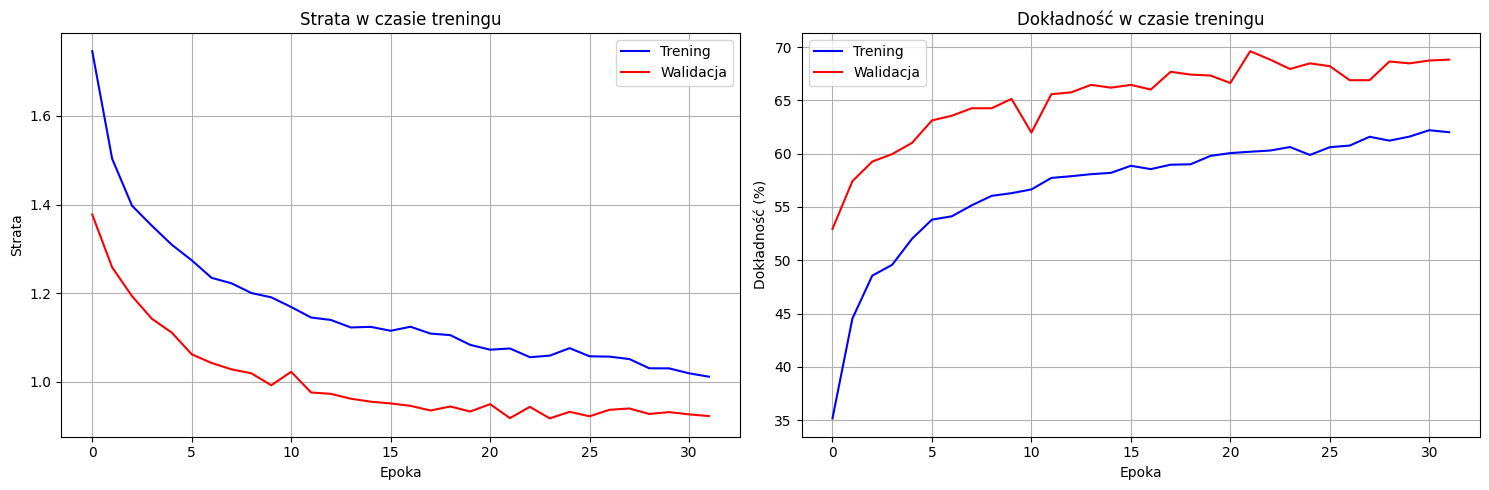


Raport klasyfikacji:
                                     precision    recall  f1-score   support

                 przesuniecie_w_dol       0.83      0.76      0.79       286
               przesuniecie_w_prawo       0.80      0.46      0.59       285
                           litera_Z       0.62      0.66      0.63       285
                           litera_V       0.72      0.64      0.68       284
                przesuniecie_w_lewo       0.74      0.64      0.68       281
   okrag_zgodnie_z_ruchem_wskazowek       0.55      0.83      0.66       286
                przesuniecie_w_gore       0.69      0.78      0.73       287
okrag_przeciwnie_do_ruchu_wskazowek       0.61      0.65      0.63       285

                           accuracy                           0.68      2279
                          macro avg       0.69      0.68      0.67      2279
                       weighted avg       0.69      0.68      0.67      2279



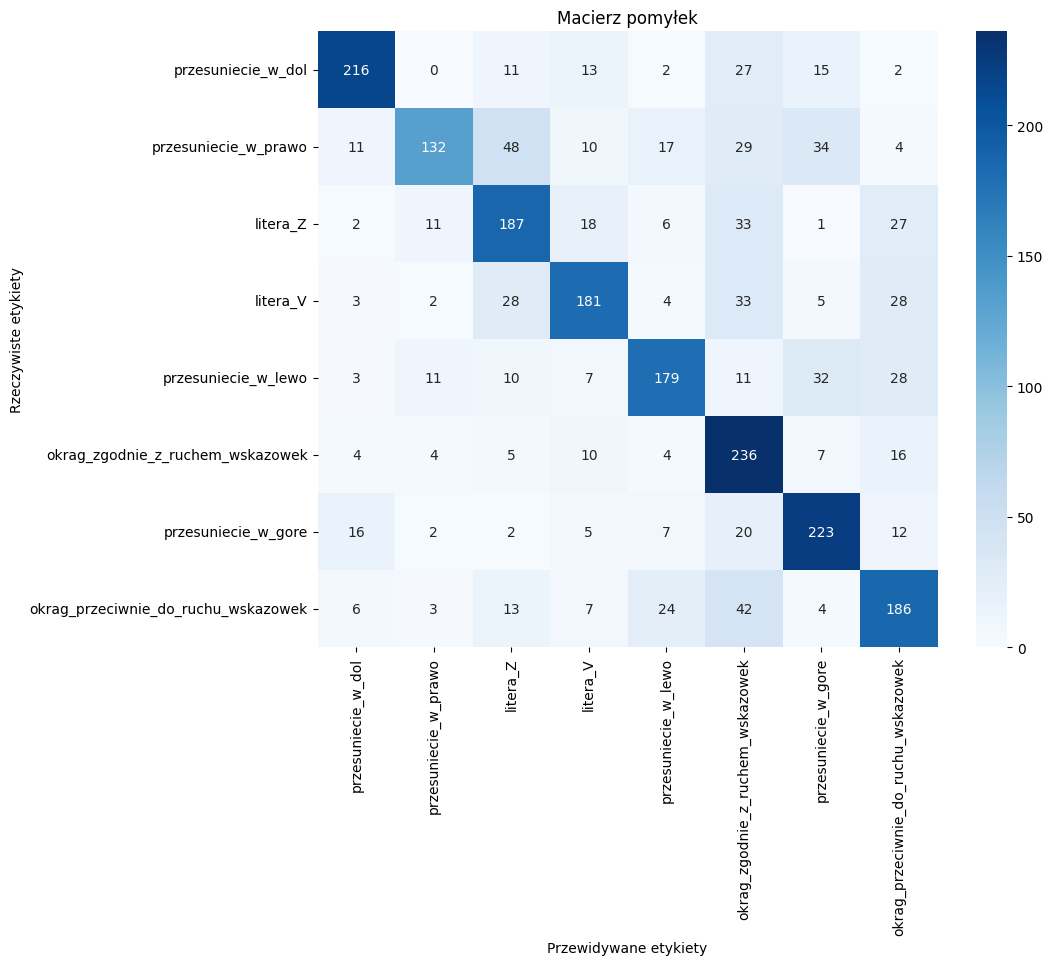


Dokładność testowa: 0.6757 (67.57%)
Model został zapisany jako 'gesture_model.pth'


In [25]:
def main():
    # Ustawienia
    DATA_DIR = '/content/data'
    WINDOW_SIZE = 50
    OVERLAP = 0.5
    BATCH_SIZE = 32
    LEARNING_RATE = 0.001
    EPOCHS = 100
    SAVE_EVERY_N_EPOCHS = 5  # Zapisuj co 5 epok

    # Sprawdzenie dostępności GPU
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"✅ Używane urządzenie: GPU ({torch.cuda.get_device_name()})")
    else:
        device = torch.device('cpu')
        print("⚠️ GPU niedostępne, używane urządzenie: CPU")

    # Przygotowanie danych
    train_dataset, val_dataset, test_dataset, class_names, scaler = prepare_data_with_sliding_window(
        DATA_DIR, WINDOW_SIZE, OVERLAP
    )

    if len(class_names) == 0:
        raise ValueError("Nie znaleziono żadnych danych! Sprawdź ścieżkę i format plików.")
    print(f"✅ Znaleziono {len(class_names)} klas gestów: {list(class_names.values())}")

    # DataLoadery
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Trenowanie modelu z zapisem co 5 epok
    input_size = WINDOW_SIZE * 3
    num_classes = len(class_names)

    model, history = train_model_advanced(
        train_loader, val_loader, input_size, num_classes,
        epochs=EPOCHS, learning_rate=LEARNING_RATE, device=device,
        save_every_n_epochs=SAVE_EVERY_N_EPOCHS  # Dodaj ten parametr
    )

    # Wizualizacja treningu
    plot_training_history(history)

    # Ewaluacja
    accuracy, predictions, labels = evaluate_model(model, test_loader, class_names, device)

    # Zapisanie modelu
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_names': class_names,
        'scaler': scaler,
        'window_size': WINDOW_SIZE,
        'input_size': input_size,
        'num_classes': num_classes
    }, '/content/gesture_model.pth')

    print("Model został zapisany jako 'gesture_model.pth'")

# Uruchomienie
if __name__ == "__main__":
    main()


## 1. Podsumowanie wyników treningu i ewaluacji
Model trenowany na 8 klasach gestów osiągnął następujące kluczowe metryki na zbiorze testowym:

Dokładność: 67.57%

Macro-F1: 0.67

Weighted-F1: 0.67

Raport klasyfikacji pokazuje rozrzut wyników dla poszczególnych gestów:

Najlepsze F1-score uzyskał gest przesuniecie_w_dol (0.79),

Najsłabsze reakcje model wykazał dla gestu okrag_zgodnie_z_ruchem_wskazowek (F1 = 0.66) oraz częściowo przesuniecie_w_prawo (F1 = 0.59).

Większość gestów osiągnęła precyzję i recall w przedziale 0.60–0.80, co w praktyce oznacza umiarkowaną, aczkolwiek niedoskonałą separację klas.

Trend podczas treningu:

Szybki spadek strat i wzrost dokładności w pierwszych 10 epokach (Train Acc. → 56%, Val Acc. → 65%),

Od epoki ~10 do 30 widoczna stagnacja metryk walidacyjnych w okolicach 66–69%,

Early stopping w epoce 32 wskazuje, że dalsze epoki nie przynosiły znaczącej poprawy.

Ogólnie, model wykrywa gesty znacznie lepiej niż losowy (12.5%), ale istnieje spory margines na poprawę (np. sięgający 90+% w standardowych scenariuszach rozpoznawania gestów).

## 2. Architektura modelu
Model to wielowarstwowa sieć w pełni połączona (MLP) o następującej strukturze:

Wejście: wektor spłaszczonych danych akcelerometru o wymiarze 150 (50 próbek × 3 osie)

Ukryte warstwy:

Linear(150 → 128) → BatchNorm → ReLU → Dropout(0.3)

Linear(128 → 64) → BatchNorm → ReLU → Dropout(0.3)

Wyjście: Linear(64 → 8) → softmax (realizowany jako CrossEntropyLoss w PyTorch)

Liczba parametrów w modelu to 28 488, co odpowiada głównie wagom w warstwach liniowych.

## 3. Ocena przydatności na STM32
Zalety
Niewielki rozmiar (~28 k parametrów, ok. 114 kB w formacie float32) – realnie poniżej 100 kB po kwantyzacji do int8.

Małe opóźnienie inferencji – pojedyncze forward pass wymaga ~30 000 operacji MAC, co przy 80 MHz rdzeniu ARM Cortex-M4/M7 X-Cube-AI może być wykonane w kilkunastu milisekundach lub krócej.

Kompatybilność z X-Cube-AI – model w ONNX można bezpośrednio zaimportować do STM32CubeMX + X-Cube-AI i wygenerować zoptymalizowany kod C.

Ograniczenia
Umiarkowana dokładność (67.6%) – w zastosowaniach krytycznych (sterowanie ruchem, VR) może być niewystarczająca. Wymaga dalszej optymalizacji danych (augmentacja, więcej próbek) lub bardziej zaawansowanej architektury (np. sieć konwolucyjna lub LSTM).

Brak sekwencyjnego modelowania – MLP nie uwzględnia kolejności czasowej poza statycznym „oknem” danych, co może ograniczać jakość rozpoznania dynamicznych gestów.